# Columnar analysis with Awkward Array

## How this works as a hands-on tutorial

Even though I don't have formal exercises scattered throughout these notebooks, this session can still be interactive.

   * **You** should open each notebook in Binder (see [GitHub README](https://github.com/jpivarski/2020-06-08-uproot-awkward-columnar-hats)) and evaluate cells, following along with me.
   * **I** should pause frequently and stay open to questions. I'll be monitoring the videoconference chat.
   * **We** should feel free to step off the path and try to answer "What if?" questions in real time.

Not all digressions will lead to an answer—I often realize, "That's why it didn't work!" long after the tutorial is over—but tinkering is how we learn.

Consider this a tour and I'm your guide. The planned route is a suggestion to get things started, but your questions and wayfaring are more important.

<br><br><br>

## Array-based programming

One of the first programming languages, named **APL** ("A Programming Language") was array-based. It started as a notation for _describing_ hand-written machine code and was later made interactive.

**Nial** was also theoretically motivated, and the two of these inspired a generation of direct descendants (green).

Meanwhile, the **S** language for statistics borrowed many of these ideas while being focused on a particular domain. Its descendent, **R**, is still widely used.

**IDL** was invented for the sciences and gained a lot of traction as an alternative to writing custom Fortran, again using vectorization as a first-class concept.

**MATLAB** was similarly gained traction in the sciences as a commercial product.

**PDL** (Perl Data Language) and **NumPy** introduced the same concepts as libraries within an established language (Perl and Python). **Julia** has some vector-like interfaces, though its focus is on just-in-time compiling imperative code.

![](img/apl-timeline.png)

<br><br><br>

Common features of array-based languages:

   * Arrays are the central data type with most operations applying to arrays. (By contrast, C requires explicit iteration over the arrays: it's imperative.)
   * They are _all_ interactive languages. The array-at-a-time logic makes it possible to define precompiled routines that run in response to user commands.
   * They are primarily data analysis languages, highly targeted to the sciences and statistics.

In retrospect, it sounds like a perfect fit to what we want to do.

<br><br><br>

In this plot of the "astronomical" rise of Python, note that 2 of the 3 languages it's displacing are array languages.

![](img/mentions-of-programming-languages.png)

<br><br><br>

## Why not for particle physics?

Because **data structures**. Particle physicists have _always_ needed to deal with complex data structures, so much so that we invented packages to add them to Fortran.

The following is from [_Initiation to HYDRA_ by R.K. Böck (1976)](https://cds.cern.ch/record/864527?ln=en) as part of an explanation of what a "data structure" is, at a time before Fortran had `FOR` loops. (HYDRA was merged into ZEBRA, which became the basis for ROOT I/O.)

We would draw similar diagrams today.

![](img/hydra-2.png)

<br><br><br>

But the modify-compile-rerun cycle of C++ is too long for interactive data analysis. That's why ROOT invented CINT and then Cling.

But C++ is too complex of a language for data-focused tasks. That's why I was thinking a lot about [extending query languages (like SQL) to data structures](https://stackoverflow.com/questions/38831961/what-declarative-language-is-good-at-analysis-of-tree-like-data).

But I was surprised by how useful the simple JaggedArray class in Uproot turned out to be. My conclusion was that you don't need a new language, just some data types and operations.

![](img/uproot-awkward-timeline.png)

<br><br><br>

<font size="15">That's what </font><img src="img/awkward-logo-300px.png" style="vertical-align:middle"><font size="15"> is.</font>


Just arrays and functions on arrays, but with awkward shapes.

![](img/cartoon-schematic.png)

<br><br><br>

## Let's start with a non-physics example

To get a feel for what this means, let's look at _something completely different_ from a Z peak: [Chicago bike paths](https://github.com/Chicago/osd-bike-routes/blob/master/data/Bikeroutes.geojson).

In [1]:
import json

bikeroutes_json = open("data/Bikeroutes.geojson").read()
bikeroutes_pyobj = json.loads(bikeroutes_json)

In [2]:
# First thousand bytes...
print(bikeroutes_json[:1000])

{
"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
                                                                                
"features": [
{ "type": "Feature", "properties": { "STREET": "W FULLERTON AVE", "TYPE": "4", "BIKEROUTE": "RECOMMENDED BIKE ROUTE", "F_STREET": "W GRAND AVE", "T_STREET": "W GRAND AVE" }, "geometry": { "type": "MultiLineString", "coordinates": [ [ [ -87.788572682391163, 41.923652047961923 ], [ -87.788645591836797, 41.923651405921802 ], [ -87.788844988373143, 41.923649881816345 ], [ -87.788950897155686, 41.923649066751238 ], [ -87.789091716222416, 41.923648060311677 ], [ -87.789279058225759, 41.923646752738705 ], [ -87.789396101278086, 41.923645907691565 ], [ -87.789781787237345, 41.923641532135363 ], [ -87.789851574317836, 41.923640764779442 ], [ -87.78989703352525, 41.923640238994977 ], [ -87.790052557345319, 41.923638477701097 ], [ -87.790253898265888, 41.92363731709856 ], [ -87.7903925124

It has a lot of structure—metadata and street names mixed in with the longitude, latitude points. But we can read it in as arrays.

In [3]:
import awkward1 as ak

bikeroutes = ak.Record(bikeroutes_pyobj)
bikeroutes

<Record ... [-87.7, 42], [-87.7, 42]]]}}]} type='{"type": string, "crs": {"type"...'>

The analysis-relevant information about the data's structure is contained in its `type`. (Note: this is [Datashape](https://datashape.readthedocs.io/en/latest/) notation, which was invented for this sort of thing.)

In [4]:
ak.type(bikeroutes)

{"type": string, "crs": {"type": string, "properties": {"name": string}}, "features": var * {"type": string, "properties": {"STREET": string, "TYPE": string, "BIKEROUTE": string, "F_STREET": string, "T_STREET": option[string]}, "geometry": {"type": string, "coordinates": var * var * var * float64}}}

Everything is a `string` or an `option[string]` (i.e. can be `null`) except the coordinates, which are `var * var * var * float64` (triply jagged array).

Let's go straight for the coordinates.

In [5]:
bikeroutes["features", "geometry", "coordinates"]

<Array [[[[-87.8, 41.9], ... [-87.7, 42]]]] type='1061 * var * var * var * float64'>

or

In [6]:
bikeroutes.features.geometry.coordinates

<Array [[[[-87.8, 41.9], ... [-87.7, 42]]]] type='1061 * var * var * var * float64'>

In [7]:
ak.to_list(bikeroutes.features.geometry.coordinates[:3])

[[[[-87.78857268239116, 41.92365204796192],
   [-87.7886455918368, 41.9236514059218],
   [-87.78884498837314, 41.923649881816345],
   [-87.78895089715569, 41.92364906675124],
   [-87.78909171622242, 41.92364806031168],
   [-87.78927905822576, 41.923646752738705],
   [-87.78939610127809, 41.923645907691565],
   [-87.78978178723735, 41.92364153213536],
   [-87.78985157431784, 41.92364076477944],
   [-87.78989703352525, 41.92364023899498],
   [-87.79005255734532, 41.9236384777011],
   [-87.79025389826589, 41.92363731709856],
   [-87.79039251240177, 41.923636326077215],
   [-87.79131231855902, 41.92362983196139],
   [-87.79145920250602, 41.923628604266135],
   [-87.79148375037359, 41.92362841824402]]],
 [[[-87.74815752805499, 41.914431860310785],
   [-87.74816482757203, 41.91443315985752],
   [-87.74819817563908, 41.914438543841555],
   [-87.74823564553337, 41.914451221037915],
   [-87.74829849193455, 41.91448927446621],
   [-87.74836277977153, 41.914546517396424],
   [-87.74841516152057, 

The third axis happens to have length 2 in all cases, but it came from JSON, which can't guarantee that lists have a certain length, so Awkward identifies it as `var` (variable-width, i.e. "jagged").

We _could_ enforce this by applying a slice that has a fixed length.

In [8]:
ak.type(bikeroutes.features.geometry.coordinates)

1061 * var * var * var * float64

In [9]:
ak.type(bikeroutes.features.geometry.coordinates[:, :, :, [0, 1]])

1061 * var * var * 2 * float64

This distinction between fixed-size and in-principle-variable size is important in general, though not very important for this example.

A more important question is, what do these levels of jaggedness represent?

Let's pick one item and print it out in full detail.

In [10]:
ak.to_list(bikeroutes.features[751])

{'type': 'Feature',
 'properties': {'STREET': 'E 26TH ST',
  'TYPE': '1',
  'BIKEROUTE': 'EXISTING BIKE LANE',
  'F_STREET': 'S STATE ST',
  'T_STREET': 'S DR MARTIN LUTHER KING JR DR'},
 'geometry': {'type': 'MultiLineString',
  'coordinates': [[[-87.62685625163756, 41.84558714841179],
    [-87.62675996392576, 41.84558902593194],
    [-87.62637708895348, 41.845596494328554],
    [-87.62626461651281, 41.845598326696425],
    [-87.62618268489398, 41.84559966093136],
    [-87.6261438116618, 41.84560027230502],
    [-87.62613206507362, 41.845600474403334],
    [-87.6261027723024, 41.8456009526551],
    [-87.62579736038116, 41.84560626159298],
    [-87.62553890383363, 41.845610239979905],
    [-87.62532611036139, 41.845613593674],
    [-87.6247932635836, 41.84562202574476]],
   [[-87.62532611036139, 41.845613593674],
    [-87.6247932635836, 41.84562202574476]],
   [[-87.6247932635836, 41.84562202574476],
    [-87.62446484629727, 41.84562675013391],
    [-87.62444032614908, 41.8456270927620

The hint is "MultiLineString": a bike route consists of disconnected lines. (I guess you have to pick up your bike and walk it.)

Most routes are a single connected line; I found this extreme using [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html), a function for jagged multiplicity.

In [11]:
ak.num(bikeroutes.features.geometry.coordinates)

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='1061 * int64'>

In [12]:
ak.argmax(ak.num(bikeroutes.features.geometry.coordinates))

751

[ak.max](https://awkward-array.readthedocs.io/en/latest/_auto/ak.max.html) is just like [np.max](https://numpy.org/doc/1.18/reference/generated/numpy.amax.html) from NumPy except that it recognizes Awkward Arrays.

By contrast, [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html) could not have a NumPy equivalent because it provides information that would always be trivial with NumPy's rectangular arrays.

Functions that overlap NumPy functions, like [ak.max](https://awkward-array.readthedocs.io/en/latest/_auto/ak.max.html) does for [np.max](https://numpy.org/doc/1.18/reference/generated/numpy.amax.html), have exactly the same interface and defaults. If you have NumPy 1.17 or above, they're actually interchangeable (NumPy recognizes that it's looking at a non-NumPy arrays and defers to our implementation).

In [13]:
import numpy as np

np.argmax(ak.num(bikeroutes.features.geometry.coordinates))

751

To fill out the pattern set by NumPy, most of the functions have an `axis` parameter indicating the depth of nestedness where you want the function to apply.

This can be particularly useful for [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html).

In [14]:
# most routes have a single contiguous path
ak.num(bikeroutes.features.geometry.coordinates, axis=1)

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='1061 * int64'>

In [15]:
# paths can have many or few longitude, latitude points
ak.num(bikeroutes.features.geometry.coordinates, axis=2)

<Array [[16], [16], [7], ... [80], [20], [11]] type='1061 * var * int64'>

In [16]:
# all of the longitude, latitude points have exactly two numbers
ak.num(bikeroutes.features.geometry.coordinates, axis=3)

<Array [[[2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2]]] type='1061 * var * var * int64'>

Notice the data type: the number of entries in deeply nested data is itself a nested structure.

We can verify that the longitude, latitude points really do have two values like this:

In [17]:
num = ak.num(bikeroutes.features.geometry.coordinates, axis=3)
num == 2

<Array [[[True, True, True, ... True, True]]] type='1061 * var * var * bool'>

In [18]:
ak.all(num == 2)

True

[ak.all](https://awkward-array.readthedocs.io/en/latest/_auto/ak.all.html) is a reducer (like [np.all](https://numpy.org/doc/1.18/reference/generated/numpy.all.html)), which turns arrays into scalars.

Its default `axis` is `None`, meaning "reduce everything." We can also partially reduce.

`axis=-1` means "deepest axis," which is the most-often useful axis, apart from `None`.

In [19]:
ak.all(num == 2, axis=-1)

<Array [[True], [True], ... [True], [True]] type='1061 * var * bool'>

So now let's do something useful: how about computing the length of each bike route?

First, get the longitude and latitude separately.

In [20]:
longitude = bikeroutes.features.geometry.coordinates[..., 0]
latitude = bikeroutes.features.geometry.coordinates[..., 1]
longitude, latitude

(<Array [[[-87.8, -87.8, ... -87.7, -87.7]]] type='1061 * var * var * float64'>,
 <Array [[[41.9, 41.9, 41.9, ... 42, 42, 42]]] type='1061 * var * var * float64'>)

The ellipsis (`...`) saved me from having to type `coordinates[:, :, :, 0]`, having to know the exact depth when I wanted the deepest. That's also a NumPy thing.

At our longtidue and latitude, one degree of longitude corresponds to 82.7 km and one degree of latitude corresponds to 111.1 km (I looked that up elsewhere).

Functions like [ak.mean](https://awkward-array.readthedocs.io/en/latest/_auto/ak.mean.html)/[np.mean](https://numpy.org/doc/1.18/reference/generated/numpy.mean.html) have the same interface as reducers.

In [21]:
km_east = (longitude - np.mean(longitude)) * 82.7
km_north = (latitude - np.mean(latitude)) * 111.1
km_east, km_north

(<Array [[[-9.68, -9.69, ... -3.58, -3.62]]] type='1061 * var * var * float64'>,
 <Array [[[6.68, 6.68, 6.67, ... 9.68, 9.72]]] type='1061 * var * var * float64'>)

So now all of the paths are in distance units (km), relative to the center of Chicago (the center of all the points at least; we only needed a convenient origin).

Think, for a moment, about what that transformation would have required to do it in "for" loops. Even if speed were not an issue, it would be a lot of typing.

To compute lengths, we need distances _between_ points. So we want to match pairs of points along each path.

The way you'd do this with a NumPy array is with slices:

In [22]:
path = np.array([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])
path[1:] - path[:-1]

array([1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1])

where `path[1:]` drops the first element and `path[:-1]` drops the last element, which is exactly what you want to subtract to get all the distances in between.

We can do the same thing with our Awkward Arrays, even though they have different lengths at the deepest level of jaggedness.

In [23]:
km_east[0, 0, :-1], km_east[0, 0, 1:]

(<Array [-9.68, -9.69, -9.7, ... -9.91, -9.92] type='15 * float64'>,
 <Array [-9.69, -9.7, -9.71, ... -9.92, -9.92] type='15 * float64'>)

In [24]:
km_east[0, 0, :-1] - km_east[0, 0, 1:]

<Array [0.00603, 0.0165, ... 0.0121, 0.00203] type='15 * float64'>

Doing it for all paths at once is no more difficult than doing it for the first path.

In [25]:
km_east[:, :, :-1] - km_east[:, :, 1:]

<Array [[[0.00603, 0.0165, ... 0.0385]]] type='1061 * var * var * float64'>

Since we're all familiar with using $\sqrt{(x_i - x_{i + 1})^2 + (y_i - y_{i + 1})^2}$ as a distance formula, let's jump to the answer.

In [26]:
segment_length = np.sqrt((km_east[:, :, 1:] - km_east[:, :, :-1])**2 +
                         (km_north[:, :, 1:] - km_north[:, :, :-1])**2)
segment_length

<Array [[[0.00603, 0.0165, ... 0.0523]]] type='1061 * var * var * float64'>

So now we have replaced paths of length _n_ (where _n_ is variable) with segment distances of length _n ‒ 1_.

We probably want the length of each path, so... reducer! This one is [ak.sum](https://awkward-array.readthedocs.io/en/latest/_auto/ak.sum.html)/[np.sum](https://numpy.org/doc/1.18/reference/generated/numpy.sum.html).

In [27]:
path_length = np.sum(segment_length, axis=-1)
path_length

<Array [[0.241], [0.0971], ... 0.347], [0.281]] type='1061 * var * float64'>

Okay, but some routes have multiple paths (though most have exactly one). These `path_lengths` have the same multiplicity as the paths.

In [28]:
ak.num(path_length), ak.num(bikeroutes.features.geometry.coordinates)

(<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='1061 * int64'>,
 <Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='1061 * int64'>)

In [29]:
ak.num(path_length) == ak.num(bikeroutes.features.geometry.coordinates)

<Array [True, True, True, ... True, True, True] type='1061 * bool'>

In [30]:
ak.all(ak.num(path_length) == ak.num(bikeroutes.features.geometry.coordinates))

True

So let's reduce again.

In [31]:
route_length = np.sum(path_length, axis=-1)
route_length

<Array [0.241, 0.0971, 0.203, ... 0.347, 0.281] type='1061 * float64'>

There you have it. We can also put this new derived column into the original array, if that's useful for anything.

(Note: you have to assign with square brackets and strings, not attributes, because attribute-assignment would lead to confusion about assigning to temporary copies. Pandas has the same problem, and they're deprecating attribute-assignemnt because of it.)

In [32]:
bikeroutes["features", "route_length"] = route_length

In [33]:
ak.to_list(bikeroutes.features[751])

{'type': 'Feature',
 'properties': {'STREET': 'E 26TH ST',
  'TYPE': '1',
  'BIKEROUTE': 'EXISTING BIKE LANE',
  'F_STREET': 'S STATE ST',
  'T_STREET': 'S DR MARTIN LUTHER KING JR DR'},
 'geometry': {'type': 'MultiLineString',
  'coordinates': [[[-87.62685625163756, 41.84558714841179],
    [-87.62675996392576, 41.84558902593194],
    [-87.62637708895348, 41.845596494328554],
    [-87.62626461651281, 41.845598326696425],
    [-87.62618268489398, 41.84559966093136],
    [-87.6261438116618, 41.84560027230502],
    [-87.62613206507362, 41.845600474403334],
    [-87.6261027723024, 41.8456009526551],
    [-87.62579736038116, 41.84560626159298],
    [-87.62553890383363, 41.845610239979905],
    [-87.62532611036139, 41.845613593674],
    [-87.6247932635836, 41.84562202574476]],
   [[-87.62532611036139, 41.845613593674],
    [-87.6247932635836, 41.84562202574476]],
   [[-87.6247932635836, 41.84562202574476],
    [-87.62446484629727, 41.84562675013391],
    [-87.62444032614908, 41.8456270927620

Now every record has a `route_length` field.

In [34]:
bikeroutes.features.route_length

<Array [0.241, 0.0971, 0.203, ... 0.347, 0.281] type='1061 * float64'>

That's how these calculations go. If we were to do the same thing with Python for loops, it would be a lot more verbose and slower.

In [35]:
%%timeit

total_length = []
for route in bikeroutes_pyobj["features"]:
    route_length = []
    for polyline in route["geometry"]["coordinates"]:
        segment_length = []
        last = None
        for lng, lat in polyline:
            km_east = lng * 82.7
            km_north = lat * 111.1
            if last is not None:
                dx2 = (km_east - last[0])**2
                dy2 = (km_north - last[1])**2
                segment_length.append(np.sqrt(dx2 + dy2))
            last = (km_east, km_north)

        route_length.append(sum(segment_length))
    total_length.append(sum(route_length))

50.2 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%%timeit

km_east = bikeroutes.features.geometry.coordinates[..., 0] * 82.7
km_north = bikeroutes.features.geometry.coordinates[..., 1] * 111.1

segment_length = np.sqrt((km_east[:, :, 1:] - km_east[:, :, :-1])**2 +
                         (km_north[:, :, 1:] - km_north[:, :, :-1])**2)

route_length = np.sum(segment_length, axis=-1)
total_length = np.sum(route_length, axis=-1)

8.82 ms ± 426 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the limit, it's a factor of 8 faster. This isn't even a _great_ speedup; other examples easily reach a factor of 100.

The point is that we're in the "fast math" regieme, where typical examples are an order of magnitude or two faster than "slow Python."

![](img/bikeroutes-scaling.png)

## Particle physics data

Now, of course, we want to see what this can do for particle physics data. This public CMS file has a million events and is often used to make dimuon spectra.

The recommended way to get Awkward 1 arrays is to read with Uproot 3 (the current version) and then call [ak.from_awkward0](https://awkward-array.readthedocs.io/en/latest/_auto/ak.from_awkward0.html).

(Uproot 4 will produce Awkward 1 arrays natively.)

In [37]:
import uproot
cms_dict = uproot.open("data/cms_opendata_2012_nanoaod_DoubleMuParked.root")["Events"].arrays()
cms_dict

{b'run': array([194778, 194778, 194778, ..., 195774, 195774, 195774], dtype=int32),
 b'luminosityBlock': array([ 51,  51,  51, ..., 503, 503, 503], dtype=uint32),
 b'event': array([ 12887941,  12963969,  13227276, ..., 819301164, 819332668,
        819398412], dtype=uint64),
 b'PV_npvs': array([ 1,  1,  1, ..., 12, 20,  9], dtype=int32),
 b'PV_x': array([0.0722459 , 0.0722459 , 0.0722459 , ..., 0.07219489, 0.07082949,
        0.06881613], dtype=float32),
 b'PV_y': array([0.06209353, 0.06209353, 0.06209353, ..., 0.06237721, 0.06023057,
        0.06337257], dtype=float32),
 b'PV_z': array([-0.0280992 , -0.0280992 , -0.0280992 , ...,  1.5894414 ,
         0.87497556, -0.6417597 ], dtype=float32),
 b'nMuon': array([2, 1, 2, ..., 2, 2, 2], dtype=uint32),
 b'Muon_pt': <JaggedArray [[52.008335 42.85704] [5.0199485] [15.967432 12.48129] ... [22.729137 3.3364584] [4.9992414 14.161738] [18.304218 9.717607]] at 0x7f7bf3f46490>,
 b'Muon_eta': <JaggedArray [[1.2523203 1.6531223] [2.1219535] [-1.241

In [38]:
cms_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in cms_dict.items()}
cms_dict_ak1

{'run': <Array [194778, 194778, ... 195774, 195774] type='1000000 * int32'>,
 'luminosityBlock': <Array [51, 51, 51, 51, ... 503, 503, 503, 503] type='1000000 * uint32'>,
 'event': <Array [12887941, 12963969, ... 819398412] type='1000000 * uint64'>,
 'PV_npvs': <Array [1, 1, 1, 1, 1, ... 11, 16, 12, 20, 9] type='1000000 * int32'>,
 'PV_x': <Array [0.0722, 0.0722, ... 0.0708, 0.0688] type='1000000 * float32'>,
 'PV_y': <Array [0.0621, 0.0621, ... 0.0602, 0.0634] type='1000000 * float32'>,
 'PV_z': <Array [-0.0281, -0.0281, ... 0.875, -0.642] type='1000000 * float32'>,
 'nMuon': <Array [2, 1, 2, 2, 2, 2, ... 4, 2, 2, 2, 2, 2] type='1000000 * uint32'>,
 'Muon_pt': <Array [[52, 42.9], [5.02, ... [18.3, 9.72]] type='1000000 * var * float32'>,
 'Muon_eta': <Array [[1.25, 1.65], ... [2.07, 1.43]] type='1000000 * var * float32'>,
 'Muon_phi': <Array [[0.842, -2.15], ... [-2.1, -3.01]] type='1000000 * var * float32'>,
 'Muon_mass': <Array [[0.106, 0.106], ... [0.106, 0.106]] type='1000000 * var

You might have noticed that the conversion was faster than the reading—actually the "conversion" only replaces old metadata with new metadata—they're the same array buffers in memory.

Switching Awkward 0 ↔ Awkward 1 is an inexpensive operation, in terms of time and memory.

Speaking of memory, I loaded these million events into memory because they're only 250 MB of RAM.

As Python objects, they're 1307 MB, 5.2× larger.

## Data as columns AND objects

NanoAOD was invented at around the same time as Uproot—the success of NanoAOD is part of what's convincing me that directly engaging in array-based programming is working for physicists.

Instead of letting C++ objects be split as an implementation detail in ROOT (see Uproot session), the data are "pre-split" into branches like `Muon_pt`, `Muon_eta`, and `Muon_phi`.

But now we can have it both ways. The branches of a NanoAOD file can be the columns of an Awkward Array with event/particle structure.

In [39]:
cms_events = ak.zip({
    "run": cms_dict_ak1["run"],
    "luminosityBlock": cms_dict_ak1["luminosityBlock"],
    "event": cms_dict_ak1["event"],
    "PV": ak.zip({
        "x": cms_dict_ak1["PV_x"],
        "y": cms_dict_ak1["PV_y"],
        "z": cms_dict_ak1["PV_z"],
    }),
    "muons": ak.zip({
        "pt": cms_dict_ak1["Muon_pt"],
        "eta": cms_dict_ak1["Muon_eta"],
        "phi": cms_dict_ak1["Muon_phi"],
        "mass": cms_dict_ak1["Muon_mass"],
        "charge": cms_dict_ak1["Muon_charge"],
        "pfRelIso04_all": cms_dict_ak1["Muon_pfRelIso04_all"],
        "tightId": cms_dict_ak1["Muon_tightId"]
    })
}, depth_limit=1)

cms_events

<Array [{run: 194778, ... ] type='1000000 * {"run": int32, "luminosityBlock": ui...'>

In [40]:
# this is the first event
ak.to_list(cms_events[0])

{'run': 194778,
 'luminosityBlock': 51,
 'event': 12887941,
 'PV': {'x': 0.07224589586257935,
  'y': 0.06209353357553482,
  'z': -0.02809920161962509},
 'muons': [{'pt': 52.00833511352539,
   'eta': 1.2523202896118164,
   'phi': 0.8424168229103088,
   'mass': 0.10565836727619171,
   'charge': 1,
   'pfRelIso04_all': -999.0,
   'tightId': False},
  {'pt': 42.85704040527344,
   'eta': 1.6531223058700562,
   'phi': -2.154824733734131,
   'mass': 0.10565836727619171,
   'charge': -1,
   'pfRelIso04_all': -999.0,
   'tightId': False}]}

In [41]:
# this is the first muon in the first event
ak.to_list(cms_events[0, "muons", 0])

{'pt': 52.00833511352539,
 'eta': 1.2523202896118164,
 'phi': 0.8424168229103088,
 'mass': 0.10565836727619171,
 'charge': 1,
 'pfRelIso04_all': -999.0,
 'tightId': False}

The above _manually_ links NanoAOD branches to record array structures, using [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html), but Nick has written a more general (and lazy) converter called [NanoEvents](https://github.com/CoffeaTeam/coffea/blob/9a29fe47fc690051be50773d262ee74e805a2f60/binder/nanoevents.ipynb) (look it up in the Coffea tools).

That is what I would recommend for analysis of NanoAOD.

## Why making and breaking record structures is okay

Zipping and projecting are essentially "free" from a computational point of view because we're just moving around metadata (i.e. _O(1)_, the computation time does not scale with the number of events).

This is easier to see with a simple example.

In [42]:
x = ak.Array([[0.0, 1.1, 2.2], [], [3.3, 4.4]])
y = ak.Array([[[], [1], [1, 2]], [], [[1, 2, 3], [1, 2, 3, 4]]])

columnar = ak.zip({"x": x, "y": y}, depth_limit=2)
columnar

<Array [[{x: 0, y: []}, ... 1, 2, 3, 4]}]] type='3 * var * {"x": float64, "y": v...'>

In [43]:
ak.to_list(columnar)

[[{'x': 0.0, 'y': []}, {'x': 1.1, 'y': [1]}, {'x': 2.2, 'y': [1, 2]}],
 [],
 [{'x': 3.3, 'y': [1, 2, 3]}, {'x': 4.4, 'y': [1, 2, 3, 4]}]]

In [44]:
ak.type(columnar)

3 * var * {"x": float64, "y": var * int64}

We've "zipped" `x` and `y` together to make records with fields named `x` and `y`.

The `depth_limit=2` ensured that the outermost level of jaggedness is shared in the output but not the innermost. Here's what would happen if `depth_limit` were `1` or `3`:

In [45]:
ak.to_list(ak.zip({"x": x, "y": y}, depth_limit=1))

[{'x': [0.0, 1.1, 2.2], 'y': [[], [1], [1, 2]]},
 {'x': [], 'y': []},
 {'x': [3.3, 4.4], 'y': [[1, 2, 3], [1, 2, 3, 4]]}]

In [46]:
ak.to_list(ak.zip({"x": x, "y": y}, depth_limit=2))

[[{'x': 0.0, 'y': []}, {'x': 1.1, 'y': [1]}, {'x': 2.2, 'y': [1, 2]}],
 [],
 [{'x': 3.3, 'y': [1, 2, 3]}, {'x': 4.4, 'y': [1, 2, 3, 4]}]]

In [47]:
ak.to_list(ak.zip({"x": x, "y": y}, depth_limit=3))

[[[], [{'x': 1.1, 'y': 1}], [{'x': 2.2, 'y': 1}, {'x': 2.2, 'y': 2}]],
 [],
 [[{'x': 3.3, 'y': 1}, {'x': 3.3, 'y': 2}, {'x': 3.3, 'y': 3}],
  [{'x': 4.4, 'y': 1},
   {'x': 4.4, 'y': 2},
   {'x': 4.4, 'y': 3},
   {'x': 4.4, 'y': 4}]]]

(The duplication of `x` fields to match `y` is called "broadcasting." The same idea [exists in NumPy](https://numpy.org/doc/stable/user/basics.broadcasting.html), but we've extended it for jaggedness.)

I've been using [ak.to_list](https://awkward-array.readthedocs.io/en/latest/_auto/ak.to_list.html) to show the array in its entirety by converting it to Python objects and letting Jupyter format them nicely.

We should be thinking about the arrays in these terms: as nested lists and records. Printing out a very small sample with [ak.to_list](https://awkward-array.readthedocs.io/en/latest/_auto/ak.to_list.html) is a great debugging technique.

But this is not how the data are laid out in memory. If you want to get into the details of how it works, look into the `layout`.

In [48]:
columnar.layout

<ListOffsetArray64>
    <offsets><Index64 i="[0 3 3 5]" offset="0" length="4" at="0x55ae91a9e050"/></offsets>
    <content><RecordArray>
        <field index="0" key="x">
            <NumpyArray format="d" shape="5" data="0 1.1 2.2 3.3 4.4" at="0x55ae9198ace0"/>
        </field>
        <field index="1" key="y">
            <ListArray64>
                <starts><Index64 i="[0 0 1 3 6]" offset="0" length="5" at="0x55ae914858f0"/></starts>
                <stops><Index64 i="[0 1 3 6 10]" offset="0" length="5" at="0x55ae91a6f040"/></stops>
                <content><NumpyArray format="l" shape="10" data="1 1 2 1 2 3 1 2 3 4" at="0x55ae91aa9360"/></content>
            </ListArray64>
        </field>
    </RecordArray></content>
</ListOffsetArray64>

This hierarchical structure of the layout mirrors the structure of the [ak.to_list](https://awkward-array.readthedocs.io/en/latest/_auto/ak.to_list.html) output with one important difference: the number of nodes scales with the complexity of the data structure, not the number of elements in the arrays. This example has 5 nodes, but if it had a million elements of the same data _type_, it will still just have 5 nodes.

All the slow, bookkeeping-type code that has to have dynamic types to address different types without recompilation only has to walk over these 5 nodes.

All the fast, vectorized code is precompiled to run over the arrays within those 5 nodes.

![](img/example-hierarchy.png)

For our `cms_events`, this means that 17 nodes represent a million events.

In [49]:
cms_events.layout

<RecordArray>
    <field index="0" key="run">
        <NumpyArray format="i" shape="1000000" data="194778 194778 194778 194778 194778 ... 195774 195774 195774 195774 195774" at="0x7f7bf0872010"/>
    </field>
    <field index="1" key="luminosityBlock">
        <NumpyArray format="I" shape="1000000" data="0x 33000000 33000000 33000000 33000000 ... f7010000 f7010000 f7010000 f7010000" at="0x7f7bf04a1010"/>
    </field>
    <field index="2" key="event">
        <NumpyArray format="L" shape="1000000" data="0x 85a7c400 00000000 81d0c500 00000000 ... 3c06d630 00000000 0c07d730 00000000" at="0x7f7befcff010"/>
    </field>
    <field index="3" key="PV">
        <RecordArray>
            <field index="0" key="x">
                <NumpyArray format="f" shape="1000000" data="0.0722459 0.0722459 0.0722459 0.0722459 0.0722459 ... 0.0728568 0.0733762 0.0721949 0.0708295 0.0688161" at="0x7f7bef55d010"/>
            </field>
            <field index="1" key="y">
                <NumpyArray format="f" 

Another consequence of this is that it's easy to "project" fields out of nested records into non-record arrays. (Again, just rearranging metadata.)

In [50]:
ak.to_list(columnar)

[[{'x': 0.0, 'y': []}, {'x': 1.1, 'y': [1]}, {'x': 2.2, 'y': [1, 2]}],
 [],
 [{'x': 3.3, 'y': [1, 2, 3]}, {'x': 4.4, 'y': [1, 2, 3, 4]}]]

In [51]:
ak.to_list(columnar.x)

[[0.0, 1.1, 2.2], [], [3.3, 4.4]]

In [52]:
ak.to_list(columnar.y)

[[[], [1], [1, 2]], [], [[1, 2, 3], [1, 2, 3, 4]]]

In [53]:
cms_events.PV.x

<Array [0.0722, 0.0722, ... 0.0708, 0.0688] type='1000000 * float32'>

In [54]:
cms_events.muons.pt

<Array [[52, 42.9], [5.02, ... [18.3, 9.72]] type='1000000 * var * float32'>

In your analysis, feel free to zip and project as much as you find useful. Records are _fluid_.

## Imperative programming

At this point, I'd usually show how slicing and combinatorics functions like [ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html) and [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html) can be used to develop an analysis.

But that gives the impression that columnar operations are the _only_ way to work. Although some operations are more convenient in this form, others are not.

Therefore, I've been putting a lot of effort into making these arrays usable from [Numba](http://numba.pydata.org/), a just-in-time compiler for Python, which lets you write standard for-loop style (imperative) code, compile it on the fly, and run it.

In [55]:
import numba as nb

@nb.jit
def Zmass(events):
    # How big of an output array should we allocate?
    numZ = 0
    for event in events:
        numZ += max(0, len(event.muons) * (len(event.muons) - 1) // 2)
    
    # Allocate the output array.
    out = np.empty(numZ, np.float64)

    # Fill the output array.
    numZ = 0
    for event in events:
        for i in range(len(event.muons)):
            for j in range(i + 1, len(event.muons)):
                m1 = event.muons[i]
                m2 = event.muons[j]
                out[numZ] = np.sqrt(2*m1.pt*m2.pt*(np.cosh(m1.eta - m2.eta) - np.cos(m1.phi - m2.phi)))
                numZ += 1

    return out

In [56]:
Zmass(cms_events)

array([ 96.08437546,  18.25135189, 101.1641765 , ...,   3.10986907,
        17.8928293 ,  14.60150863])

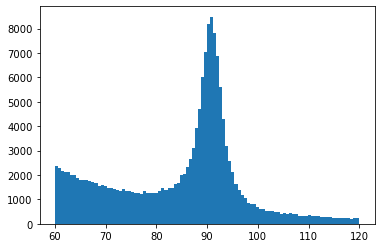

In [57]:
import matplotlib.pyplot as plt

plt.hist(Zmass(cms_events), bins=100, range=(60, 120));

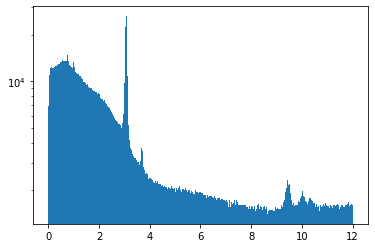

In [58]:
plt.hist(Zmass(cms_events), bins=300, range=(0, 12))
plt.yscale("log")

Now the precise way the events were zipped _is_ important. With a flatter structure, the code would have to be entirely different:

In [59]:
cms_events_flat = ak.zip(cms_dict_ak1, depth_limit=1)
ak.type(cms_events_flat)

1000000 * {"run": int32, "luminosityBlock": uint32, "event": uint64, "PV_npvs": int32, "PV_x": float32, "PV_y": float32, "PV_z": float32, "nMuon": uint32, "Muon_pt": var * float32, "Muon_eta": var * float32, "Muon_phi": var * float32, "Muon_mass": var * float32, "Muon_charge": var * int32, "Muon_pfRelIso04_all": var * float32, "Muon_tightId": var * bool}

In [60]:
@nb.jit
def Zmass_flat(events):
    numZ = 0
    for event in events:
        numZ += max(0, event.nMuon * (event.nMuon - 1) // 2)
    out = np.empty(numZ, np.float64)

    numZ = 0
    for event in events:
        for i in range(event.nMuon):
            for j in range(i + 1, event.nMuon):
                pt1 = event.Muon_pt[i]    # muons are not objects containing pt, eta, phi
                pt2 = event.Muon_pt[j]    # the Muon_pt, Muon_eta, Muon_phi arrays are separate
                eta1 = event.Muon_eta[i]
                eta2 = event.Muon_eta[j]
                phi1 = event.Muon_phi[i]
                phi2 = event.Muon_phi[j]
                out[numZ] = np.sqrt(2*pt1*pt2*(np.cosh(eta1 - eta2) - np.cos(phi1 - phi2)))
                numZ += 1
    return out

Text(0.5, 0, 'log(mass)')

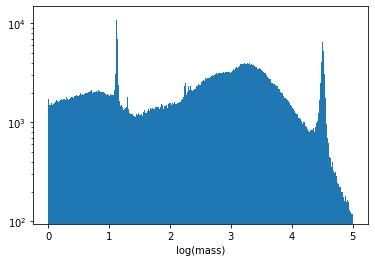

In [61]:
with np.errstate(divide="ignore"):
    plt.hist(np.log(Zmass(cms_events)), bins=1000, range=(0, 5))
plt.yscale("log")
plt.xlabel("log(mass)")

If you'd rather write conventional loop-style analysis code, then Numba may be the best way to do it.

The advantage **Numba** brings is that the compilation is fast, doesn't take you out of the interactive environment, and is identical to Python code that you can test on small samples.

The advantage **Awkward Array** brings is efficiently getting data from ROOT files into Numba compiled functions. Numba's builtin interface acceps NumPy arrays, which are unstructured, and Python objects, which are slow to "unbox" into statically typed values. Awkward keeps the columnar ROOT data columnar with static types for compilation.

There are some **limitations**, however:

   * Numba publishes a list of [Python language features](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html) and [NumPy functions](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html) that it supports. You have to learn the "sublanguage" of Python that can be statically typed and compiled.
   * Array-at-a-time functions in the Awkward Array library are not supported: in a compiled function, you _must_ use imperative code.
   * Awkward Arrays are read-only. Therefore, you can't create new arrays inside a compiled function.

## Creating arrays in a Numba-compiled function

In the above example, the output was a NumPy array because Numba supports the creation and filling of NumPy arrays.

If the derived quantities you want to create are "flat" in that sense, outputting NumPy is a good option. Note that this includes boolean arrays that you might use to cut an Awkward Array outside of the compiled function:

In [62]:
@nb.jit
def event_has_z(event):
    for i in range(len(event.muons)):
        for j in range(i + 1, len(event.muons)):
            m1 = event.muons[i]
            m2 = event.muons[j]
            mass = np.sqrt(2*m1.pt*m2.pt*(np.cosh(m1.eta - m2.eta) - np.cos(m1.phi - m2.phi)))
            if 60 < mass and mass < 120:
                return True
    return False

@nb.jit
def has_z(events):
    i = 0
    out = np.empty(len(events), np.bool_)
    for event in events:
        out[i] = event_has_z(event)
        i += 1
    return out

mask = has_z(cms_events)
mask

array([ True, False, False, ..., False, False, False])

In [63]:
cms_events[mask]

<Array [{run: 194778, ... ] type='141230 * {"run": int32, "luminosityBlock": uin...'>

In this case, what we wanted and got in the end is a data structure, but Numba only had to return a flat array of booleans.

However, there will be cases when you want to get a data structure out. [ak.ArrayBuilder](https://awkward-array.readthedocs.io/en/latest/_auto/ak.ArrayBuilder.html) is intended for that.

In [64]:
@nb.jit
def Zcandidates(events, builder):
    for event in events:

        # Begin a list in the output, like printing "["
        builder.begin_list()

        for i in range(len(event.muons)):
            for j in range(i + 1, len(event.muons)):
                m1 = event.muons[i]
                m2 = event.muons[j]
                mass = np.sqrt(2*m1.pt*m2.pt*(np.cosh(m1.eta - m2.eta) - np.cos(m1.phi - m2.phi)))
                if 60 < mass and mass < 120:

                    # Begin a record in the output, like printing "{"
                    builder.begin_record()

                    builder.field("mass")
                    builder.append(mass)

                    builder.field("muon1")
                    builder.append(m1)

                    builder.field("muon2")
                    builder.append(m2)

                    # End a record in the output, like printing "}"
                    builder.end_record()

        # End a list in the output, like printing "]"
        builder.end_list()

    return builder

In [65]:
builder = Zcandidates(cms_events, ak.ArrayBuilder())
builder

<ArrayBuilder [[{mass: 96.1, muon1: {, ... [], []] type='var * {"mass": float64,...'>

This ak.ArrayBuilder is not an array, but it can quickly (i.e. zero-copy) become one by calling `snapshot`.

In [66]:
builder.snapshot()

<Array [[{mass: 96.1, muon1: {, ... [], []] type='1000000 * var * {"mass": float...'>

This array has a lot of structure: each element is a list of records with a `mass` (float), `muon1` (another record), and `muon2` (another record).

In [67]:
ak.type(builder.snapshot())

1000000 * var * {"mass": float64, "muon1": {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32, "pfRelIso04_all": float32, "tightId": bool}, "muon2": {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32, "pfRelIso04_all": float32, "tightId": bool}}

In [68]:
ak.to_list(builder.snapshot()[0])

[{'mass': 96.08437546227617,
  'muon1': {'pt': 52.00833511352539,
   'eta': 1.2523202896118164,
   'phi': 0.8424168229103088,
   'mass': 0.10565836727619171,
   'charge': 1,
   'pfRelIso04_all': -999.0,
   'tightId': False},
  'muon2': {'pt': 42.85704040527344,
   'eta': 1.6531223058700562,
   'phi': -2.154824733734131,
   'mass': 0.10565836727619171,
   'charge': -1,
   'pfRelIso04_all': -999.0,
   'tightId': False}}]

An ArrayBuilder makes arrays whose type is determined by the _order in which its methods are called_:

```
b = ak.ArrayBuilder()

# fill commands   # as JSON   # current array type
##########################################################################################
b.begin_list()    # [         # 0 * var * unknown     (initially, the type is unknown)
b.integer(1)      #   1,      # 0 * var * int64
b.integer(2)      #   2,      # 0 * var * int64
b.real(3)         #   3.0     # 0 * var * float64     (all the integers have become floats)
b.end_list()      # ],        # 1 * var * float64
b.begin_list()    # [         # 1 * var * float64
b.end_list()      # ],        # 2 * var * float64
b.begin_list()    # [         # 2 * var * float64
b.integer(4)      #   4,      # 2 * var * float64
b.null()          #   null,   # 2 * var * ?float64    (now the floats are nullable)
b.integer(5)      #   5       # 2 * var * ?float64
b.end_list()      # ],        # 3 * var * ?float64
b.begin_list()    # [         # 3 * var * ?float64
b.begin_record()  #   {       # 3 * var * ?union[float64, {}]
b.field("x")      #     "x":  # 3 * var * ?union[float64, {"x": unknown}]
b.integer(1)      #      1,   # 3 * var * ?union[float64, {"x": int64}]
b.field("y")      #      "y": # 3 * var * ?union[float64, {"x": int64, "y": unknown}]
b.begin_list()    #      [    # 3 * var * ?union[float64, {"x": int64, "y": var * unknown}]
b.integer(2)      #        2, # 3 * var * ?union[float64, {"x": int64, "y": var * int64}]
b.integer(3)      #        3  # 3 * var * ?union[float64, {"x": int64, "y": var * int64}]
b.end_list()      #      ]    # 3 * var * ?union[float64, {"x": int64, "y": var * int64}]
b.end_record()    #   }       # 3 * var * ?union[float64, {"x": int64, "y": var * int64}]
b.end_list()      # ]         # 4 * var * ?union[float64, {"x": int64, "y": var * int64}]
```

It is a bit like writing JSON from a script, except that it fills columnar data structures, rather than writing text.

Thus, it is very important to close each `begin_X` with an `end_X` (at the right place) to avoid making enormous, unclosed data structures! Try your scripts on small samples (outside of Numba) before scaling up.

The `append` method is a synonym for `null`, `boolean`, `integer`, `real`, etc., determining its type from its argument. In Numba, that type-determination happens at compile-time (fast). But it can also insert whole data structures, like `muon1` and `muon2` in the Z candidates above. The muons are inserted _by reference_ (not copied).

One more caveat: since ArrayBuilder is dynamically typed and its length scales dynamically (like `std::vector`), it's slower than filling a NumPy array:

In [69]:
@nb.jit
def fill_with_numpy():
    out = np.empty(10000000, np.int64)
    for i in range(10000000):
        out[i] = i
    return out

@nb.jit
def fill_with_builder(builder):
    for i in range(10000000):
        builder.integer(i)
    return builder

# run them each once to not count the compilation step in the timing below
fill_with_numpy()
fill_with_builder(ak.ArrayBuilder());

In [70]:
%%timeit

fill_with_numpy()

24.1 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
%%timeit

fill_with_builder(ak.ArrayBuilder())

257 ms ± 7.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


I had to make the workload trivial (just filling with increasing numbers) to see such a dramatic difference, but there's a factor of 10 right there.

If what you're doing is moderately complex, then the distinction is hidden by the rest of the workload (e.g. only a factor of 2 for filling with `np.random.normal(0, 1)` and no visible difference when filling Z candidates).

So if it's just as easy to fill NumPy arrays and [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) them or use them as slices later, then do so.

## And now, columnar analysis

We can analyze physics data like the way we analyzed the Chicago bike routes: by slicing, projecting, and zipping nested data structures.

We could start with a Z peak, the "hello world" of particle physics because it has minimal, non-trivial combinatorics.

It's actually easier than the imperative code in the Numba examples if you have functions like [ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html) and [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html).

### Cartesian (cross) products

[ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html) makes all possible pairs (or triples, etc.) from two (or three, etc.) collections.

If `axis=1` (the default), it does so for each list in arrays of lists.

![](img/cartoon-cartesian.png)

In [72]:
ak.cartesian(([[  1,   2, 3], [   ], [4       ]],
              [["a", "b"   ], ["c"], ["d", "e"]])).tolist()

[[(1, 'a'), (1, 'b'), (2, 'a'), (2, 'b'), (3, 'a'), (3, 'b')],
 [],
 [(4, 'd'), (4, 'e')]]

### Combinations

[ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html) makes all possible pairs (or triples, etc.) of a collection with itself, without duplicates.

If `axis=1` (the default), it does so for each list in an array of lists.

![](img/cartoon-combinations.png)

In [73]:
ak.combinations([[1, 2, 3, 4], [], [5, 6]], 2).tolist()

[[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)], [], [(5, 6)]]

### Applying this to the Z peak

To make a Z peak, we must consider all possible pairs of muons, without duplicates.

In the columnar analysis way of thinking, we make those pairs before we've fully decided what we're going to do with them.

In [74]:
pairs = ak.combinations(cms_events.muons, 2)
pairs

<Array [[({pt: 52, ... tightId: True})]] type='1000000 * var * ({"pt": float32, ...'>

In [75]:
ak.type(pairs)

1000000 * var * ({"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32, "pfRelIso04_all": float32, "tightId": bool}, {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32, "pfRelIso04_all": float32, "tightId": bool})

It would be more convenient if the "left muon" and "right muon" in each pair were in separate arrays.

That's an easy operation with projection/zipping/etc.

In [76]:
m1, m2 = ak.unzip(pairs)
m1, m2

(<Array [[{pt: 52, ... tightId: True}]] type='1000000 * var * {"pt": float32, "et...'>,
 <Array [[{pt: 42.9, ... tightId: True}]] type='1000000 * var * {"pt": float32, "...'>)

Now we can just apply the formula, vectorially.

In [77]:
mass = np.sqrt(2*m1.pt*m2.pt*(np.cosh(m1.eta - m2.eta) - np.cos(m1.phi - m2.phi)))
mass

<Array [[96.1], [], [18.3, ... [17.9], [14.6]] type='1000000 * var * float32'>

This array still has event structure (some events have zero pairs, others have several).

We can plot it now to see what the data look like, but we have to flatten it. (Note: the default [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html) axis is 1.)

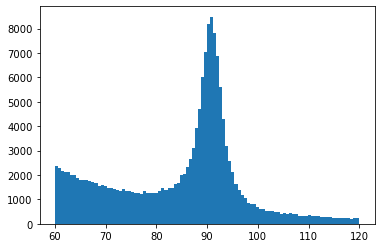

In [78]:
plt.hist(ak.flatten(mass), bins=100, range=(60, 120));

The next step would probably be to filter non-Z dimuons. We do that by making an array of booleans and slicing the array with it, as in NumPy.

Note that `and` and `or` don't work for (vectorized) logic on arrays. Just as in NumPy, we're forced to use `&` and `|`, which has a different operator precedence, so I put expressions in parentheses for safety.

In [79]:
mask = (60 < mass) & (mass < 120)
mask

<Array [[True], [], ... [False], [False]] type='1000000 * var * bool'>

Unlike NumPy slicing, this is a _jagged_ array of booleans, but that's fine for masking a jagged array, as long as the lengths of all sublists match.

In [80]:
mass[mask]

<Array [[96.1], [], [], ... [], [], [], []] type='1000000 * var * float32'>

Now we can make a Z record structure, just like the one we built with an ak.ArrayBuilder in Numba.

In [81]:
z_records = ak.zip({"mass": mass[mask], "muon1": m1[mask], "muon2": m2[mask]})
z_records

<Array [[{mass: 96.1, muon1: {, ... [], []] type='1000000 * var * {"mass": float...'>

In [82]:
ak.type(z_records)

1000000 * var * {"mass": float32, "muon1": {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32, "pfRelIso04_all": float32, "tightId": bool}, "muon2": {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32, "pfRelIso04_all": float32, "tightId": bool}}

In [83]:
ak.to_list(z_records[0])

[{'mass': 96.0843734741211,
  'muon1': {'pt': 52.00833511352539,
   'eta': 1.2523202896118164,
   'phi': 0.8424168229103088,
   'mass': 0.10565836727619171,
   'charge': 1,
   'pfRelIso04_all': -999.0,
   'tightId': False},
  'muon2': {'pt': 42.85704040527344,
   'eta': 1.6531223058700562,
   'phi': -2.154824733734131,
   'mass': 0.10565836727619171,
   'charge': -1,
   'pfRelIso04_all': -999.0,
   'tightId': False}}]

## Cuts on particles, cuts on events

The jagged array of booleans is an Awkward extension of NumPy's slicing syntax.

We use it to make a distinction between filtering particles:

In [84]:
cms_events.muons[cms_events.muons.pt > 50]

<Array [[{pt: 52, eta: 1.25, ... [], []] type='1000000 * var * {"pt": float32, "...'>

and filtering events:

In [85]:
cms_events[ak.any(cms_events.muons.pt > 50, axis=1)]

<Array [{run: 194778, ... ] type='53369 * {"run": int32, "luminosityBlock": uint...'>

To filter particles, the array must be a jagged array of booleans:

In [86]:
cms_events.muons.pt > 50

<Array [[True, False], ... [False, False]] type='1000000 * var * bool'>

and to filter particles, it must be a flat array of booleans:

In [87]:
ak.any(cms_events.muons.pt > 50, axis=1)

<Array [True, False, False, ... False, False] type='1000000 * bool'>

Here, we used a reducer, [ak.any](https://awkward-array.readthedocs.io/en/latest/_auto/ak.any.html), to turn a list of `True`/`False` for each muon into a single `True`/`False` for the event.

You can read it as, "Select CMS events in which any CMS events' muons' $p_T$ is greater than 50."

The `axis=1` is to apply to the first level of lists-within-the-array.

## Cutting vs masking

Cuts eliminate events (or particles), which may have two different intentions:

   1. to reduce the size of the dataset so that it's more manageable on disk or in memory;
   2. to improve statistical significance by eliminating backgrounds.

For rare signals, (1) implies (2), though they're usually broken into stages: coarse cuts and fine cuts.

Assuming that we're concerned with (2) only, it can be a _problem_ that cutting eliminates data because most array-at-a-time functions assume that their arguments align: element `i` of the first array corresponds to element `i` of the second array.

Cuts break that relationship.

In [88]:
# applying the same cut to all arguments is okay
ak.zip({"mass": mass[mask], "muon1": m1[mask], "muon2": m2[mask]})

<Array [[{mass: 96.1, muon1: {, ... [], []] type='1000000 * var * {"mass": float...'>

In [89]:
# applying the cut after the operation is okay
ak.zip({"mass": mass, "muon1": m1, "muon2": m2})[mask]

<Array [[{mass: 96.1, muon1: {, ... [], []] type='1000000 * var * {"mass": float...'>

In [90]:
# but applying the cut to two out of three arguments is bad
ak.zip({"mass": mass[mask], "muon1": m1[mask], "muon2": m2})

ValueError: in ListOffsetArray64, cannot broadcast nested list

Worse still, applying _nearly the same, but not quite_ cuts is terrible.

(It would be terrible in imperative code, too, but without an error message.)

### Masking

One of the data types that Awkward Array provides allows values to be `None` (the "option" type, represented by `?` or `option[XYZ]`).

If we `mask`, rather than cut, arrays and lists within arrays maintain their lengths, but `None` values are inserted where bad/background values were.

In [91]:
# cutting particles
cms_events.muons[cms_events.muons.pt > 50]

<Array [[{pt: 52, eta: 1.25, ... [], []] type='1000000 * var * {"pt": float32, "...'>

In [92]:
# masking particles
cms_events.muons.mask[cms_events.muons.pt > 50]

<Array [[{pt: 52, eta: 1.25, ... [None, None]] type='1000000 * var * ?{"pt": flo...'>

In [93]:
# cutting events
cms_events[ak.any(cms_events.muons.pt > 50, axis=1)]

<Array [{run: 194778, ... ] type='53369 * {"run": int32, "luminosityBlock": uint...'>

In [94]:
# masking events
cms_events.mask[ak.any(cms_events.muons.pt > 50, axis=1)]

<Array [{run: 194778, ... None, None] type='1000000 * ?{"run": int32, "luminosit...'>

All of the Awkward operations are aware of option types and have rules for how to handle them.

In [95]:
masked_muons = cms_events.muons.mask[cms_events.muons.pt > 50]

masked_muons["pz"] = masked_muons.pt * np.sinh(masked_muons.eta)
masked_muons.pz

<Array [[83.5, None], ... [None, None]] type='1000000 * var * ?float32'>

Including Numba.

In [96]:
@nb.njit
def find_first_high_pt(events, threshold):
    for event in events:
        for muon in event:
            if muon is None:
                pass
            elif muon.pt > threshold:
                return muon
    return None

In [97]:
ak.to_list(find_first_high_pt(masked_muons, 1000))

{'pt': 1106.1651611328125,
 'eta': 0.05474609509110451,
 'phi': 1.084844708442688,
 'mass': 0.10565836727619171,
 'charge': 1,
 'pfRelIso04_all': -999.0,
 'tightId': False,
 'pz': 60.588478088378906}

## Pandas!

Awkward Arrays can be columns in a Pandas DataFrame. (It was possible in Awkward 0, but made more general now.)

In [98]:
import pandas as pd

df = pd.DataFrame({"data": columnar})
df

,data
0,"[{x: 0, y: []}, {x: 1.1, y: [1]}, {x: 2.2, y: ..."
1,[]
2,"[{x: 3.3, y: [1, 2, 3]}, {x: 4.4, y: [1, 2, 3,..."


But it's not clear that this is the most useful form, since Pandas doesn't have any operations that know what to do with Awkward Arrays.

NumPy functions, at least, pass through.

In [99]:
df + 100

,data
0,"[{x: 100, y: []}, {x: 101, y: [101]}, {x: 102,..."
1,[]
2,"[{x: 103, y: [101, 102, 103]}, {x: 104, y: [10..."


It is perhaps more useful to "explode" an Awkward Array into a DataFrame, such that the DataFrame cells are simple numbers. Then, at least, Pandas operations will know what to do with the data.

This is the [ak.pandas.df](https://awkward-array.readthedocs.io/en/latest/ak.pandas.df.html) function.

In [100]:
ak.pandas.df(cms_events)

run luminosityBlock      event        PV            \
                                                           x         y   
entry  subentry                                                          
0      0         194778              51   12887941  0.072246  0.062094   
       1         194778              51   12887941  0.072246  0.062094   
1      0         194778              51   12963969  0.072246  0.062094   
2      0         194778              51   13227276  0.072246  0.062094   
       1         194778              51   13227276  0.072246  0.062094   
...                 ...             ...        ...       ...       ...   
999997 1         195774             503  819301164  0.072195  0.062377   
999998 0         195774             503  819332668  0.070829  0.060231   
       1         195774             503  819332668  0.070829  0.060231   
999999 0         195774             503  819398412  0.068816  0.063373   
       1         195774             503  819398412  0.068816  0.063373   

                               muons                                       \
                        z         pt       eta       phi      mass charge   
entry  subentry                                                             
0      0        -0.028099  52.008335  1.252320  0.842417  0.105658      1   
       1        -0.028099  42.857040  1.653122 -2.154825  0.105658     -1   
1      0        -0.028099   5.019948  2.121953  1.721264  0.105658      1   
2      0        -0.028099  15.967432 -1.241451 -2.818323  0.105658     -1   
       1        -0.028099  12.481290 -0.795609 -1.516058  0.105658      1   
...                   ...        ...       ...       ...       ...    ...   
999997 1         1.589441   3.336458 -1.314498  1.389034  0.105658     -1   
999998 0         0.874976   4.999241  1.022114 -0.709204  0.105658     -1   
       1         0.874976  14.161738  0.070553  3.119483  0.105658      1   
999999 0        -0.641760  18.304218  2.073999 -2.099591  0.105658      1   
       1        -0.641760   9.717607  1.429812 -3.007432  0.105658     -1   

                                        
                pfRelIso04_all tightId  
entry  subentry                         
0      0           -999.000000   False  
       1           -999.000000   False  
1      0           -999.000000   False  
2      0           -999.000000   False  
       1           -999.000000   False  
...                        ...     ...  
999997 1              3.883366   False  
999998 0           -999.000000   False  
       1              2.073981    True  
999999 0              0.702204    True  
       1              1.496109    True  

[2366345 rows x 13 columns]

Now the event numbers ("entry") are distinguished from the particle numbers ("subentry"), and the nesting of records becomes hierarchical columns.

However, this isn't an exact representation:

   * event-level quantities (like PV) are duplicated for each particle;
   * events with zero particles drop event-level quantities entirely;
   * two particle types with different jaggedness (i.e. different numbers of jets and muons in each event) don't have a natural mapping onto the same "subentry" numbers, though you can force it with the `how` parameter (tells Pandas how to JOIN different multiplicities, as in the previous Uproot tutorial).